### **Taller 3**
*Camilo Arciniegas - Alexander Torres*

Empleando la información del número de ocupados en miles de personas (Ocupados) para las 13 principales ciudades, encuentre el mejor pronóstico para los próximos 6 meses empleando los métodos vistos en la clase. Compare
los resultados con el mejor modelo encontrado en el ejercicio anterior. 

Escriba un breve informe de máximo una página de texto que explique cómo llega a sus proyeccciones y presente las proyecciones. Aclare en el texto cuáles serían las limitaciones de sus pronósticos.

In [1445]:
# Verificación: pmdarima funciona en Python 3.11
import pmdarima
print("✅ pmdarima funciona! Versión:", pmdarima.__version__)

# Importaciones originales
from pmdarima.arima import auto_arima
from pmdarima.utils import acf,pacf
from pmdarima.arima import ARIMA
import pandas as pd
import numpy as np 
from statsmodels.sandbox.stats.runs import runstest_1samp # prueba de rachas de Wald y Wolfowitz
import statsmodels.api as sm # prueba de Box-Pierce y la modificación de Ljung-Box
from matplotlib import pyplot as plt # gráficos 
import pylab as py
from scipy import stats
from datetime import datetime
from dateutil.relativedelta import relativedelta
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

print("✅ Todas las librerías cargadas correctamente!")

✅ pmdarima funciona! Versión: 2.0.4
✅ Todas las librerías cargadas correctamente!


In [1446]:
# Configuración de gráficos
import matplotlib.pyplot as plt

# Configuración matplotlib para el proyecto
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Montserrat', 'Arial', 'DejaVu Sans', 'Liberation Sans'],
    'figure.figsize': (12, 6),
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'legend.fontsize': 10,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'lines.linewidth': 0.75,
    'grid.alpha': 0.3,
    'axes.facecolor': '#fafcff',  # Azul hielo muy suave (Alice Blue)
    'axes.edgecolor': "#2E86AB",  # Azul océano principal
    'axes.prop_cycle': plt.cycler(color=[
        '#1F77B4',  # Azul matplotlib
        '#FF7F0E',  # Naranja matplotlib
        '#2CA02C',  # Verde matplotlib
        '#D62728',  # Rojo matplotlib
        '#9467BD',  # Púrpura matplotlib
        '#8C564B'   # Marrón matplotlib
    ])
})


In [1447]:
data = pd.read_excel("https://raw.githubusercontent.com/profedaniel86/Series_de_Tiempo/refs/heads/main/1.Intro/datosEmpleo.xlsx",index_col='mes',parse_dates=True)
data.head()

,TD_13ciudades,Ocupados,Desocupados,Inactivos
mes,,,,
2001-01-01,20.946380,6923.604,1834.507,4600.718
2001-02-01,19.894213,7037.746,1747.820,4596.805
2001-03-01,19.221565,6945.973,1652.823,4807.120
2001-04-01,17.888575,6973.079,1519.137,4937.280
2001-05-01,17.945654,6994.462,1529.720,4928.911


**Separación de datos en train y test**

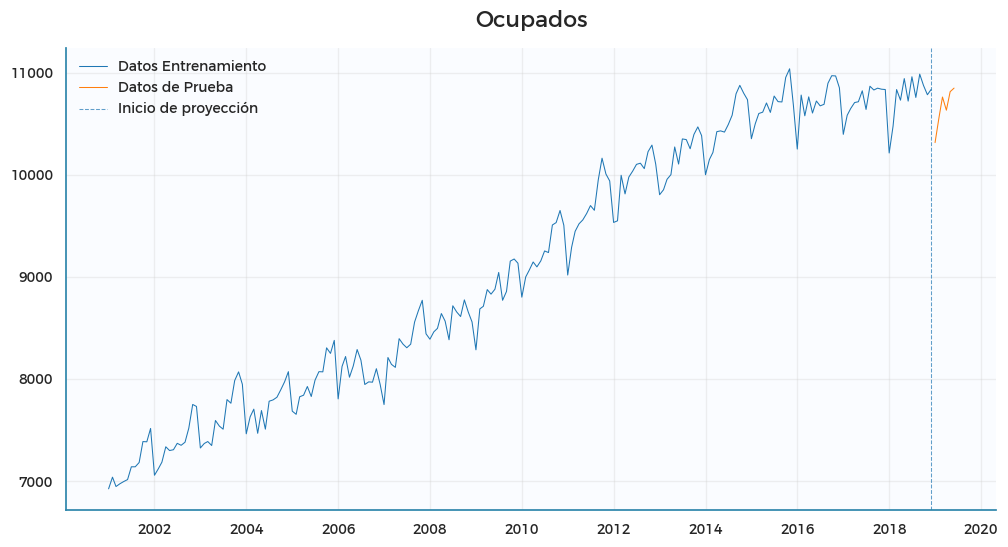

In [1448]:
train_len = 216
train_to = data[["Ocupados"]][:train_len]
test_to = data[["Ocupados"]][train_len:]

fig = plt.figure()
plt.plot(train_to,label="Datos Entrenamiento")
plt.plot(test_to,label="Datos de Prueba")
plt.axvline(train_to.index[-1], linestyle='--', alpha=0.7, label='Inicio de proyección') 
plt.title(label="Ocupados")
plt.legend(loc= "upper left")
plt.show()

In [1449]:
acf(train_to,100)

array([ 1.        ,  0.97842804,  0.96254063,  0.94808429,  0.93477526,
        0.92393405,  0.91046441,  0.90073659,  0.88761281,  0.87748064,
        0.86908695,  0.86549053,  0.86309578,  0.84411388,  0.82691131,
        0.81146819,  0.79951989,  0.78851595,  0.77597231,  0.76502544,
        0.75213945,  0.740503  ,  0.73218145,  0.72674709,  0.72199376,
        0.70369971,  0.68410682,  0.66723623,  0.65249806,  0.64108316,
        0.62638433,  0.61429322,  0.60189809,  0.58947513,  0.5809789 ,
        0.57375215,  0.56801817,  0.54842667,  0.52869507,  0.51218875,
        0.49768442,  0.48450853,  0.4682706 ,  0.456033  ,  0.44089964,
        0.42711236,  0.41606849,  0.40739871,  0.39919994,  0.37915863,
        0.35887866,  0.34160531,  0.32659754,  0.31306374,  0.29715509,
        0.28467646,  0.27009911,  0.25739113,  0.24794753,  0.23996231,
        0.23268562,  0.21266434,  0.1961713 ,  0.1815364 ,  0.1690833 ,
        0.15619882,  0.14252805,  0.13098196,  0.11534791,  0.10

hay una alta correlación en los datos

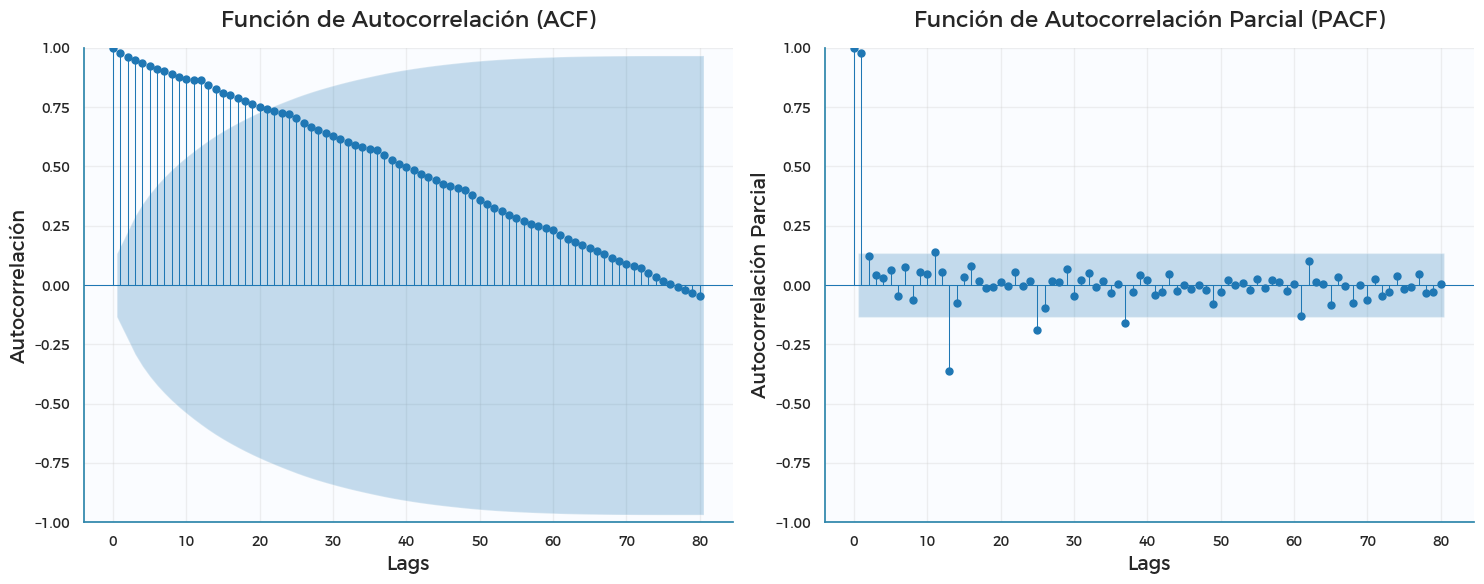

In [1450]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# ACF subplot
plot_acf(train_to, lags=80, ax=ax1, title='Función de Autocorrelación (ACF)')
ax1.set_xlabel('Lags')
ax1.set_ylabel('Autocorrelación')

# PACF subplot  
plot_pacf(train_to, lags=80, ax=ax2, title='Función de Autocorrelación Parcial (PACF)')
ax2.set_xlabel('Lags')
ax2.set_ylabel('Autocorrelación Parcial')

plt.tight_layout()
plt.show()

**Autoarima**

In [1451]:
## information_criterion (‘aic’, ‘aicc’, ‘bic’, ‘hqic’, ‘oob’)
model = auto_arima(train_to,max_p=10, max_q=10,information_criterion = ("aic"), trace=True)
model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.79 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2864.791, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2855.272, Time=0.04 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.79 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2864.791, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2855.272, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2846.080, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2864.805, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2846.080, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2864.805, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2825.418, Time=0.21 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2825.418, Time=0.21 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2826.765, Time=0.35 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2826.765, Time=0.35 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  216
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1408.709
Date:               sáb, 15 nov. 2025   AIC                           2825.418
Time:                        13:25:51   BIC                           2838.901
Sample:                    01-01-2001   HQIC                          2830.866
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     10.2480      2.382      4.303      0.000       5.580      14.916
ar.L1          0.4446      0.096      4.642      0.000       0.257       0.632
ma.L1         -0.8707      0.049    -17.901      0.000      -0.966      -0.775
sigma2      2.853e+04   2438.811     11.699      0.000    2.38e+04    3.33e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                47.82
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               1.21   Skew:                            -0.92
Prob(H) (two-sided):                  0.42   Kurtosis:                         4.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

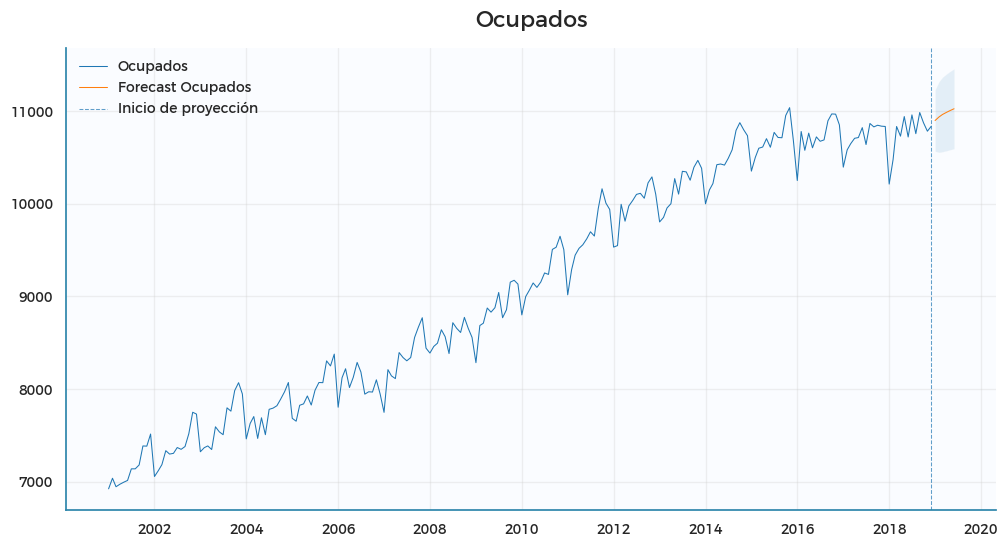

In [1452]:
h=6

y_forec, conf_int  = model.predict(h,return_conf_int=True,alpha=0.05)
preds = pd.DataFrame(np.column_stack([y_forec,conf_int[:,0] , conf_int[:,1]]))
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']


fig = plt.figure()  # Quitado figsize explícito
plt.plot(train_to.index, train_to['Ocupados'], label="Ocupados")
plt.plot(y_forec.index, preds['Point_forecast'],label="Forecast Ocupados")
plt.fill_between(y_forec.index,preds['lower_95'], preds['upper_95'], alpha=0.1)
plt.axvline(train_to.index[-1], linestyle='--', alpha=0.7, label='Inicio de proyección')
plt.title(label="Ocupados")
plt.legend(loc= "upper left")
plt.show()

In [1453]:
# Calcular RMSE del modelo autoarima
print("Datos reales (test):")
print(test_to["Ocupados"].values)
print("\nPredicciones autoarima:")
print(preds['Point_forecast'].values)

# Calcular RMSE del autoarima
rmse_autoarima = np.sqrt(mean_squared_error(test_to["Ocupados"].values, preds['Point_forecast'].values))

print(f"\nRMSE del modelo autoarima: {rmse_autoarima:.2f}")

Datos reales (test):
[10314.438 10557.917 10760.776 10632.028 10813.    10848.   ]

Predicciones autoarima:
[10898.2226713  10936.40458854 10963.62951378 10985.98259419
 11006.16948957 11025.39322669]

RMSE del modelo autoarima: 346.24


**Mismo modelo pero sin autoarima**

In [1454]:
model = ARIMA(order=(1,1,1))
results = model.fit(train_to)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  216
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1408.709
Date:               sáb, 15 nov. 2025   AIC                           2825.418
Time:                        13:25:52   BIC                           2838.901
Sample:                    01-01-2001   HQIC                          2830.866
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     10.2480      2.382      4.303      0.000       5.580      14.916
ar.L1          0.4446      0.096      4.642      0.000       0.257       0.632
ma.L1         -0.8707      0.049    -17.901      0.000      -0.966      -0.775
sigma2      2.853e+04   2438.811     11.699      0.000    2.38e+04    3.33e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                47.82
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               1.21   Skew:                            -0.92
Prob(H) (two-sided):                  0.42   Kurtosis:                         4.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [1455]:
h= 6
res = results.resid()

my_samples = []
for _ in range(train_to["Ocupados"].shape[0]):
    x = np.random.choice(res, size=h, replace=True)
    my_samples.append(x)

q1=np.quantile(my_samples,0.025,axis=0)
q2=np.quantile(my_samples,0.975,axis=0)

fore = results.predict(h,return_conf_int=False)

preds = pd.DataFrame(np.column_stack([fore,fore+np.cumsum(q1) , fore+np.cumsum(q2)]))
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']

# Generar fechas consecutivas a partir del siguiente período
start_date = train_to.index[-1] 
future_dates = pd.date_range(start=start_date, periods=h+1, freq='MS')[1:]
preds.index = future_dates

preds

,Point_forecast,lower_95,upper_95
2019-01-01,10898.222671,10517.059737,11170.295826
2019-02-01,10936.404589,10091.053409,11484.008369
2019-03-01,10963.629514,9684.219537,11783.306449
2019-04-01,10985.982594,9224.306705,12077.732684
2019-05-01,11006.169490,8870.817971,12405.010577
2019-06-01,11025.393227,8529.401175,12701.146214


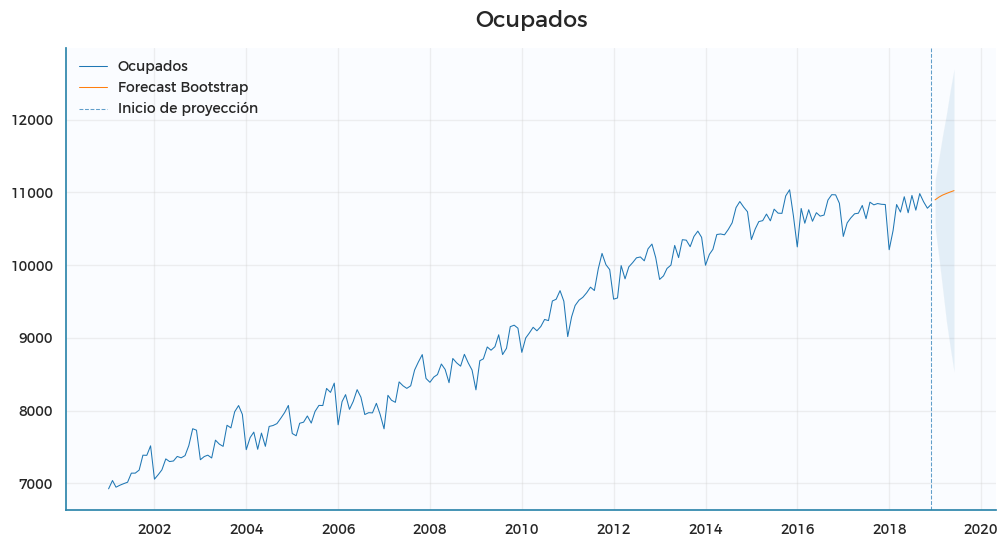

In [1456]:
fig = plt.figure()  # Quitado figsize explícito
plt.plot(train_to.index, train_to["Ocupados"], label="Ocupados")
plt.plot(preds.index, preds['Point_forecast'], label="Forecast Bootstrap")
plt.axvline(train_to.index[-1], linestyle='--', alpha=0.7, label='Inicio de proyección')
plt.fill_between(preds.index, preds['lower_95'], preds['upper_95'], alpha=0.1)
plt.title(label="Ocupados")
plt.legend(loc= "upper left")
plt.show()

In [1457]:
# Calcular RMSE comparando predicciones bootstrap con datos de prueba
print("Datos reales (test):")
print(test_to["Ocupados"].values)
print("\nPredicciones bootstrap:")
print(preds['Point_forecast'].values)

# Calcular RMSE
from sklearn.metrics import mean_squared_error
rmse_bootstrap = np.sqrt(mean_squared_error(test_to["Ocupados"].values, preds['Point_forecast'].values))

print(f"\nRMSE del modelo bootstrap: {rmse_bootstrap:.2f}")

Datos reales (test):
[10314.438 10557.917 10760.776 10632.028 10813.    10848.   ]

Predicciones bootstrap:
[10898.2226713  10936.40458854 10963.62951378 10985.98259419
 11006.16948957 11025.39322669]

RMSE del modelo bootstrap: 346.24


In [1458]:
# Comparación de modelos
print("="*60)
print("COMPARACIÓN DE MODELOS")
print("="*60)

# Del modelo autoarima (primera predicción)
print(f"MODELO AUTOARIMA:")
print(f"  RMSE: {rmse_autoarima:.2f}")
print()

# Del modelo bootstrap 
print(f"MODELO BOOTSTRAP ARIMA(1,1,1):")
print(f"  RMSE: {rmse_bootstrap:.2f}")

COMPARACIÓN DE MODELOS
MODELO AUTOARIMA:
  RMSE: 346.24

MODELO BOOTSTRAP ARIMA(1,1,1):
  RMSE: 346.24


   La diferencia está en los intervalos de confianza:
   - Autoarima: Usa intervalos paramétricos
   - Bootstrap: Usa intervalos simulados via bootstrap

## Autoarima y validación de supuestos ##

En esta sección se hace el nuevo modelo con todos los datos, para la predicción final y la prueba de supuestos

In [1459]:
## information_criterion (‘aic’, ‘aicc’, ‘bic’, ‘hqic’, ‘oob’)
model2 = auto_arima(data["Ocupados"],max_p=10, max_q=10,information_criterion = ("aic"), trace=True)
model2.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2950.596, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2940.100, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2930.671, Time=0.12 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2950.596, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2940.100, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2930.671, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2950.516, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2911.190, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2950.516, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2911.190, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2912.742, Time=0.23 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2912.742, Time=0.23 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  222
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1451.595
Date:               sáb, 15 nov. 2025   AIC                           2911.190
Time:                        13:25:54   BIC                           2924.782
Sample:                    01-01-2001   HQIC                          2916.678
                         - 06-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      9.8551      2.485      3.965      0.000       4.984      14.726
ar.L1          0.4419      0.101      4.357      0.000       0.243       0.641
ma.L1         -0.8618      0.053    -16.414      0.000      -0.965      -0.759
sigma2      2.948e+04   2480.399     11.885      0.000    2.46e+04    3.43e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                57.86
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               1.29   Skew:                            -0.99
Prob(H) (two-sided):                  0.28   Kurtosis:                         4.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [1460]:
#Le estoy quitando a los residuos del model el primer dato, 
# ya que como se compara con nada, genera un dato outier que afecta los 
# supuestos del modelo
residuos2 = model2.resid()[1:]
residuos2

mes
2001-02-01    159.981701
2001-03-01    -38.696295
2001-04-01     28.345016
2001-05-01     22.031179
2001-06-01     18.259687
                 ...    
2019-02-01    -33.944117
2019-03-01     56.155415
2019-04-01   -179.849546
2019-05-01     73.008212
2019-06-01      8.094891
Length: 221, dtype: float64

Text(0.5, 1.0, 'Residuos')

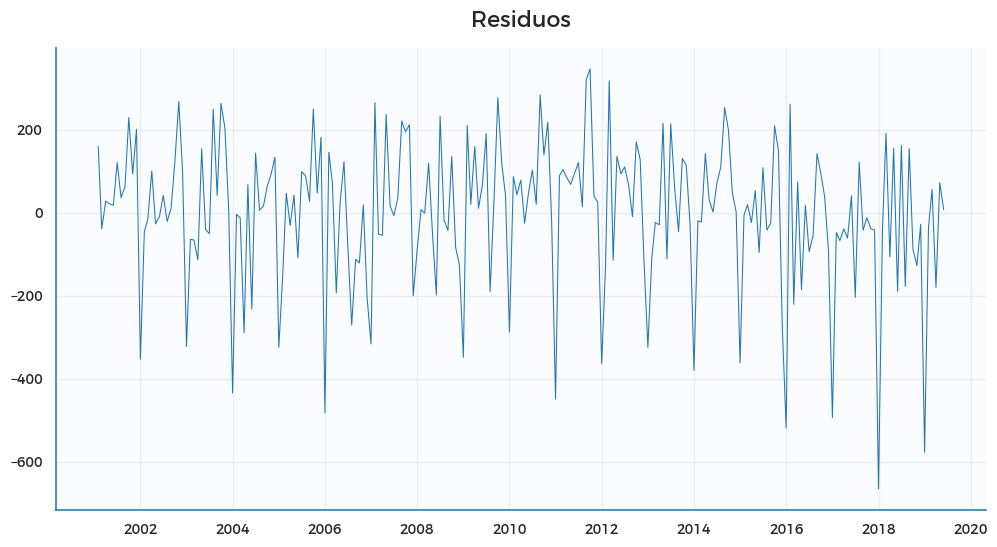

In [1461]:
fig = plt.figure()
plt.plot(residuos2,label="Residuales")
plt.title("Residuos")

## Validación de supuestos del modelo ARIMA

Voy a revisar si los residuales del modelo cumplen con los supuestos básicos:

=== AUTOCORRELACIÓN ===
Test Ljung-Box: p-valor = 0.000000
✗ HAY autocorrelación


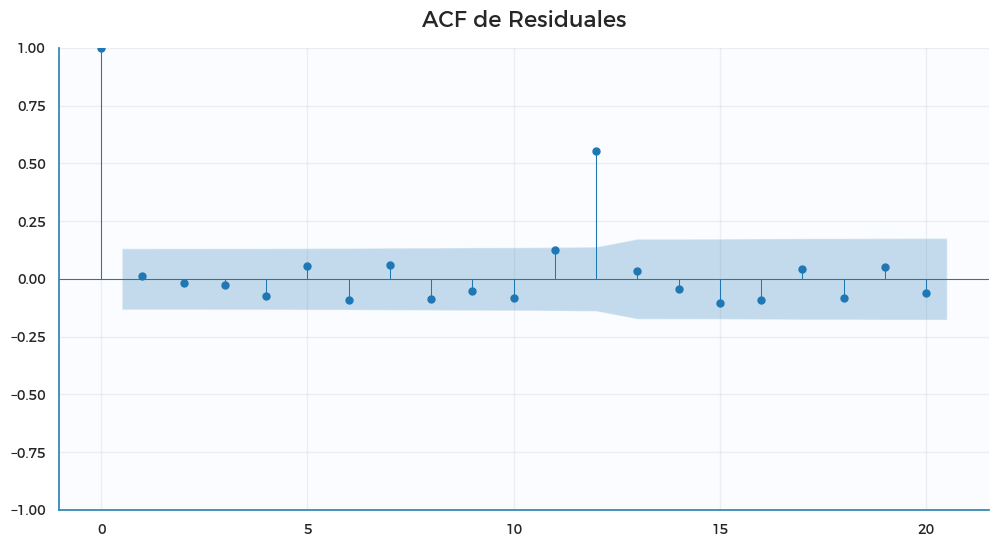

In [1462]:
# 1. SUPUESTO: NO AUTOCORRELACIÓN
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import stats
import pandas as pd

print("=== AUTOCORRELACIÓN ===")
ljung_autocorr = acorr_ljungbox(residuos2, lags=24)['lb_pvalue'].iloc[-1]
print(f"Test Ljung-Box: p-valor = {ljung_autocorr:.6f}")

if ljung_autocorr > 0.05:
    print("✓ No hay autocorrelación")
else:
    print("✗ HAY autocorrelación")
    
# Gráfico ACF
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuos2, lags=20, title="ACF de Residuales")
plt.show()

=== NORMALIDAD ===
Test Shapiro-Wilk: p-valor = 0.000000
Test Jarque-Bera: p-valor = 0.000000
✗ Los residuales NO son normales


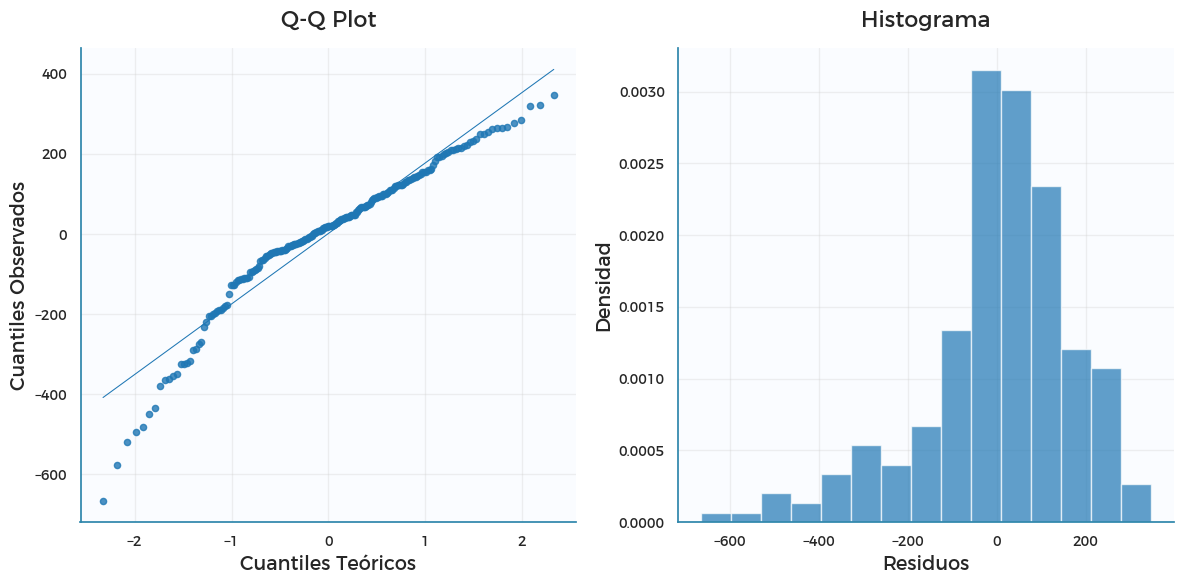

In [1463]:
# 2. SUPUESTO: NORMALIDAD
print("=== NORMALIDAD ===")

# Shapiro-Wilk
shapiro_pvalue = stats.shapiro(residuos2)[1]
print(f"Test Shapiro-Wilk: p-valor = {shapiro_pvalue:.6f}")

# Jarque-Bera
jb_pvalue = stats.jarque_bera(residuos2)[1]
print(f"Test Jarque-Bera: p-valor = {jb_pvalue:.6f}")

if shapiro_pvalue > 0.05 and jb_pvalue > 0.05:
    print("✓ Los residuales son normales")
else:
    print("✗ Los residuales NO son normales")

# Gráficos
fig, (ax1, ax2) = plt.subplots(1, 2)

# Q-Q Plot manual con matplotlib (usa automáticamente tu paleta)
import numpy as np
from scipy import stats

# Calcular cuantiles para Q-Q plot
sorted_residuos = np.sort(residuos2)
n = len(sorted_residuos)
theoretical_quantiles = stats.norm.ppf(np.linspace(0.01, 0.99, n))

# Graficar Q-Q plot
ax1.scatter(theoretical_quantiles, sorted_residuos, alpha=0.8, s=20)
# Línea de referencia simple (regresión lineal de los cuantiles)
slope, intercept = np.polyfit(theoretical_quantiles, sorted_residuos, 1)
ax1.plot(theoretical_quantiles, slope * theoretical_quantiles + intercept)
ax1.set_xlabel("Cuantiles Teóricos")
ax1.set_ylabel("Cuantiles Observados")
ax1.set_title("Q-Q Plot")
ax1.grid(True, alpha=0.3)

# Histograma
ax2.hist(residuos2, bins=15, density=True, alpha=0.7)
ax2.set_title("Histograma")
ax2.set_xlabel("Residuos")
ax2.set_ylabel("Densidad")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

=== HOMOSCEDASTICIDAD ===
Test Ljung-Box (res²): p-valor = 0.565826
Test Breusch-Pagan: p-valor = 0.189033
✓ Varianza constante (homoscedasticidad)


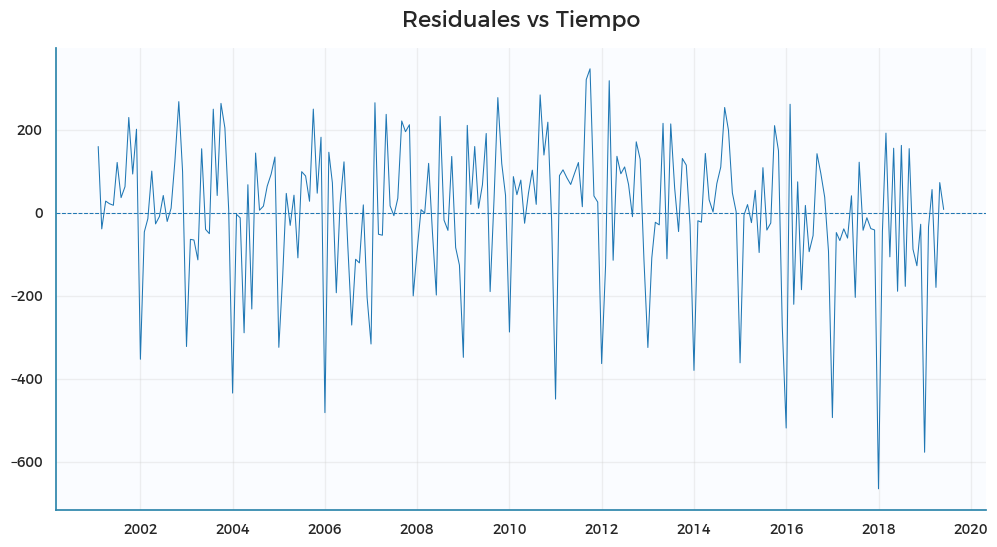

In [1464]:
# 3. SUPUESTO: HOMOSCEDASTICIDAD
from statsmodels.stats.diagnostic import het_breuschpagan
import statsmodels.api as sm

print("=== HOMOSCEDASTICIDAD ===")

# Ljung-Box en residuos²
ljung_hetero = acorr_ljungbox(residuos2**2, lags=10)['lb_pvalue'].iloc[-1]
print(f"Test Ljung-Box (res²): p-valor = {ljung_hetero:.6f}")

# Breusch-Pagan
tiempo = np.arange(len(residuos2)).reshape(-1, 1)
tiempo_const = sm.add_constant(tiempo)
bp_pvalue = het_breuschpagan(residuos2, tiempo_const)[1]
print(f"Test Breusch-Pagan: p-valor = {bp_pvalue:.6f}")

if ljung_hetero > 0.05 and bp_pvalue > 0.05:
    print("✓ Varianza constante (homoscedasticidad)")
else:
    print("✗ Varianza NO constante (heteroscedasticidad)")

# Gráfico
plt.figure()
plt.plot(residuos2)
plt.axhline(y=0, linestyle='--')
plt.title("Residuales vs Tiempo")
plt.show()

In [1465]:
# RESUMEN: Tabla de resultados
resultados = pd.DataFrame({
    'Supuesto': ['No Autocorrelación', 'Normalidad', 'Normalidad', 'Homoscedasticidad', 'Homoscedasticidad'],
    'Prueba': ['Ljung-Box', 'Shapiro-Wilk', 'Jarque-Bera', 'Ljung-Box (res²)', 'Breusch-Pagan'],
    'P-valor': [ljung_autocorr, shapiro_pvalue, jb_pvalue, ljung_hetero, bp_pvalue],
    'Cumple': ['✓' if ljung_autocorr > 0.05 else '✗',
               '✓' if shapiro_pvalue > 0.05 else '✗',
               '✓' if jb_pvalue > 0.05 else '✗',
               '✓' if ljung_hetero > 0.05 else '✗',
               '✓' if bp_pvalue > 0.05 else '✗']
})

print("TABLA RESUMEN DE SUPUESTOS:")
print(resultados.to_string(index=False))

TABLA RESUMEN DE SUPUESTOS:
          Supuesto           Prueba      P-valor Cumple
No Autocorrelación        Ljung-Box 1.272445e-20      ✗
        Normalidad     Shapiro-Wilk 1.250534e-07      ✗
        Normalidad      Jarque-Bera 3.053778e-13      ✗
 Homoscedasticidad Ljung-Box (res²) 5.658258e-01      ✓
 Homoscedasticidad    Breusch-Pagan 1.890332e-01      ✓


Agrego la numeración a la data de entrenamiento para poder correr el modelo

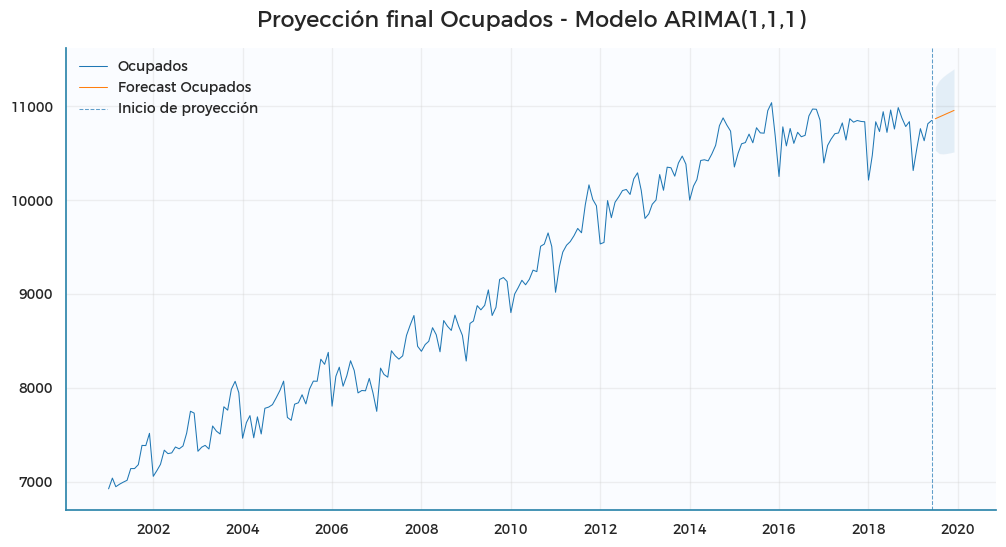

In [1466]:
h=6

y_forec, conf_int  = model2.predict(h,return_conf_int=True,alpha=0.05)
preds = pd.DataFrame(np.column_stack([y_forec,conf_int[:,0] , conf_int[:,1]]))
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']

# Generar fechas futuras correctas
start_date = data.index[-1]
future_dates = pd.date_range(start=start_date, periods=h+1, freq='MS')[1:]
preds.index = future_dates

fig = plt.figure(figsize=(12, 6))
plt.plot(data.index,data["Ocupados"],label="Ocupados")
plt.plot(preds.index,preds['Point_forecast'],label="Forecast Ocupados")
plt.fill_between(preds.index,preds['lower_95'], preds['upper_95'], alpha=0.1)
plt.axvline(data.index[-1], linestyle='--', alpha=0.7, label='Inicio de proyección') 
plt.title(label="Proyección final Ocupados - Modelo ARIMA(1,1,1)")
plt.legend(loc= "upper left")
plt.show()

In [1467]:
# Crear tabla de resultados del pronóstico
forecast_table = preds.copy()

# Formatear las fechas para mostrar como texto legible
forecast_table['Fecha'] = forecast_table.index.strftime('%d/%m/%Y')

# Reorganizar columnas y renombrar
forecast_table = forecast_table[['Fecha', 'Point_forecast', 'lower_95', 'upper_95']]
forecast_table.columns = ['Fecha', 'Pronóstico', 'Límite inferior (95%)', 'Límite superior (95%)']

# Mostrar la tabla
print("TABLA DE RESULTADOS DEL PRONÓSTICO")
print("="*70)
print(forecast_table.to_string(index=False, float_format='%.2f'))

TABLA DE RESULTADOS DEL PRONÓSTICO
     Fecha  Pronóstico  Límite inferior (95%)  Límite superior (95%)
01/07/2019    10866.35               10529.82               11202.87
01/08/2019    10884.31               10495.27               11273.35
01/09/2019    10902.10               10491.03               11313.16
01/10/2019    10919.82               10495.52               11344.12
01/11/2019    10937.50               10503.14               11371.87
01/12/2019    10955.17               10512.07               11398.28


## Conclusiones

El modelo ARIMA presenta fallas en algunos supuestos clave, específicamente en autocorrelación y normalidad. Esto limita la confiabilidad de los pronósticos.